# VLSI - SAT Model

[1] https://web.telegram.org/cd003ba1-9c37-41f3-9be7-dceeb848b5e2

[2] https://sourceforge.net/p/potassco/mailman/attachment/1323943585.4102.431.camel@white.sevalidation.com/1/

#### Definition of the problem
**Input**: A set *R = {r1, . . . , rn}* of *n* rectangles. Each rectangle
*ri ∈ R* has a width *w_i* and a height *h_i* *(w_i, h_i ∈ N)*. A Strip of
width *W ∈ N*.

**Constraints**: Each rectangle cannot overlap with the others
and the edges of the strip and must be parallel to the horizontal
and the vertical axis.

**Question**: What is the minimum height such that the set of
rectangles can be packed in the given strip?

In [ ]:
!pip3 install z3-solver

In [1]:
import os,sys,inspect,getopt
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import time
from z3 import *

currentdir = os.path.dirname(os.path.realpath("__file__"))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 
import utils

### Useful functions 

In [2]:
def write_file(W, H, n, w, h, x, y, out_file):
    with open(out_file, 'w+') as f_out:
        f_out.write('{} {}\n'.format(W, H))
        f_out.write('{}\n'.format(n))

        for i in range(n):
            f_out.write('{} {} {} {}\n'.format(w[i], h[i], x[i], y[i]))


def read(filename):
    with open(filename) as file:  # Use file to refer to the file object
        first_line = file.readline().strip().split(" ")

        width = int(first_line[0])
        height = int(first_line[1])

        n = int(file.readline().strip())

        # Read all the remaining lines which contains the horizontal and vertical dimension of the i-th circuit
        # and its bottom left corner coordinate
        remaining_lines = file.readlines()

        # To remove \n
        remaining_lines = [line.strip() for line in remaining_lines if line.strip()]

        circuits = []
        solution = {'corners': []}

        for i in range(n):
            line = remaining_lines[i]
            line = line.split()
            circuits.append((int(line[0]), int(line[1])))
            solution['corners'].append((int(line[2]), int(line[3])))
        # Solution
    sol = {
        "w": width,
        "h": height,
        "n": n,
        "points" : np.array(circuits,\
                            dtype=[('w','i4'),('h','i4')])
    }


    #print(sol['points'])
    #print([(x+1,y+1) for (x,y) in solution['corners']])

    a = sol['points']
    b = solution['corners']

    l = [[sol['w'], sol['h']]]
    for i in range(len(a)):
        l.append([a[i][0],a[i][1],b[i][0]+1,b[i][1]+1])
    return l 

def getCoords(m, x, y, W, H, n):
    x_sol = []
    y_sol = [] 
    
    for i in range(n):
        j = 0
        while j < W:
            if m.evaluate(x[i][j]):
                x_sol.append(j)
                break
            j += 1

        j = 0
        while j < H:
            if m.evaluate(y[i][j]):
                y_sol.append(j)
                break
            j += 1

    return [x_sol, y_sol]
#     return [[e for e in range(W) if m.evaluate(x[i][e])] for i in range(n)],\
#             [[f for f in range(W) if m.evaluate(y[i][f])] for i in range(n)]


def display_solution(title, W, H, n, sizes_circuits, pos_circuits):
    fig, ax = plt.subplots()
    cmap = plt.cm.get_cmap('Set3', n)
    #ax = plt.gca()
    plt.title(title)
    
    if len(pos_circuits) > 0:
        for i in range(n):
            rect = plt.Rectangle([pos_circuits[i][0]-1,pos_circuits[i][1]-1], *sizes_circuits[i], edgecolor="#333", facecolor=cmap(i))
            ax.add_patch(rect)
            rx, ry = rect.get_xy()
            cx = rx + rect.get_width()/2.0
            cy = ry + rect.get_height()/2.0
            ax.annotate(i+1, (cx, cy), color='black', weight='bold', ha='center', va='center')
    ax.set_xlim(0, W)
    ax.set_ylim(0, H)
    
    plt.xticks([])
    plt.yticks([])
    #ax.set_xticks(range(W + 1))
    #ax.set_yticks(range(H + 1))
    #ax.set_yticklabels([])
    #ax.set_xticklabels([])

    plt.show()

### Model

Set the instance.

In [3]:
'''
 # SEARCH SPACE REDUCTION 
    1. Large Rectangles (LR): 
        Reducing the possibilities for placing large rectangles.
        For each rectangle ri and r j, if wi + w j > W we can not pack
        these rectangles in the horizontal direction. We therefore
        modify non-overlapping constraints.
        This technique is also applicable for the vertical direction.

    2. Same Rectangles (SR):
        For each rectangle ri and r j, if (wi, hi) = (w j, h j) we can 
        fix the positional relation of these rectangles. 
        
    3. Largest Rectangle (LS): 
        Reducing the domain for the largest rectangle.
        With breaking symmetries, we can reduce the domain of
        largest rectangle.

                    D(x_i) = {a ∈ N | 0 ≤ a ≤ floor((W − w_i)/2)}
                    D(y_i) = {a ∈ N | 0 ≤ a ≤ floor((H − h_i)/2)}
'''

def large_rectangles(w_i, w_j, h_i, h_j, W, H):
    if w_i + w_j <= W and h_i + h_j <= H:
        return ""
    elif w_i + w_j > W and h_i + h_j <= H:
        return "W"
    elif w_i + w_j <= W and h_i + h_j > H:
        return "H"

def same_rectangles(w1,w2,h1,h2):
    if w1 == w2 and h1 == h2:
        return True
    else:
        return False

def largest_rectangle(idx, max_idx):
    if idx == max_idx:
        return True
    else:
        return False

def vlsi_sat(instance):
    
    ''' VARIABLES '''

    n = instance['n']
    W = instance['w']
    widths  = [i[0] for i in instance['dim']]
    heights = [i[1] for i in instance['dim']]

    areas = [w*h for w,h in zip(widths,heights)]
    
    largest_idx = areas.index(max(areas))
#     largest_r = max(areas)
#     rest = areas.copy()
#     rest.pop(largest_idx)
#     mean_r = int(sum(rest) / len(rest))
    
#     print(largest_idx, largest_r, mean_r)
    
    Hmax=sum(heights)
    tot_area=sum([w*h for w,h in zip(widths,heights)])

    lb = int(tot_area/W)
#     ub = int(2*max( 
#                 max([[p[0],p[1]] for p in instance['dim']],key=lambda p:p[0]*p[1]) [1] #Height of the block with the largest area
#                 ,lb))+1 
    ub = (3*lb)/2
    
    H = lb
    s_time = time.time()
    
    while (lb < ub):
        if (time.time() > s_time + 300):
            print("Out of time")
            return s, px, py, H, 0.0
        
        ''' SOLVER WITH 5 MINUTES TIMEOUT'''
        s = Solver()
        s.set("timeout", 300000)

        
        '''
        ==================================================================
        Let x_i and y_i be integer variables such that the pair (x_i, y_i)
        represents the position of lower left coordinates of the rectangle
        ri in the strip.
        The domains of x_i and y_i are as folbows.
                            D(x_i) = {a ∈ N | 0 ≤ a ≤ W − w_i}
                            D(y_i) = {a ∈ N | 0 ≤ a ≤ H − h_i}
        ==================================================================
        Let r_i, r_j ∈ R(i != j) be two rectangles. We use two
        kinds of propositional variables: lr_i,j and ud_i,j.
        lr_i,j is true if r_i are placed at the left to the r_j.
        ud_i,j is true if r_i are placed at the downward to the r_j.

        ==================================================================
        For each rectangles r_i,r_j (i < j), we have the non-overlapping
        constraints:
                            lr_i,j ∨ lr_j,i ∨ ud_i,j ∨ ud_j,i
                                ¬lr_i,j ∨ (x_i + w_i ≤ x_j)
                                ¬lr_j,i ∨ (x_j + w_j ≤ x_i)
                                ¬ud_i,j ∨ (y_i + h_i ≤ y_j)
                                ¬ud_j,i ∨ (y_j + h_j ≤ y_i)
        The parts between parentheses are encoded into SAT by using order
        encoding.
        '''
        px = [[Bool(f"px{i+1}_{x}") for x in range(W)] for i in range(n)] # x[i][i]: block i has y coordinate <=j
        py = [[Bool(f"py{i+1}_{y}") for y in range(H)] for i in range(n)] # x[i][i]: block i has y coordinate <=j
        lr = [[Bool(f"lr_{i+1}_{j+1}") if j!=i else 0 for j in range(n)] for i in range(n)]
        ud = [[Bool(f"ud_{i+1}_{j+1}") if i!=j else 0 for j in range(n)] for i in range(n)]

        # Exactly One constraint
        for i in range(n): 
            '''
            ==================================================================
            Order encoding is a generalization of the encoding method
            originally used by Crawford and Baker for Job-Shop
            Scheduling problems.
            It uses a different Boolean variable P_x,a representing x ≤ a
            for each integer variable x and integer value a.
            
            For each rectangle r_i, and integer e and f such that
            0 ≤ e ≤ W − wi and 0 ≤ f ≤ H − h_i, we have the 2-literal
            axiom clauses due to order encoding,
                                ¬ px_i,e ∨ px_i,e+1
                                ¬ py_i, f ∨ py_i, f +1
            ==================================================================
            '''
            
            # LS 
            if largest_rectangle(i, largest_idx):
                s.add([px[i][e] for e in range(int((W-widths[i])/2),W)]) # block i starts for sure before position W-wi-> x[i][j]=True for all j > W-wi 
                s.add([py[i][f] for f in range(int((H-heights[i])/2),H)]) # same for the y coordinate 
            else:
                s.add([px[i][e] for e in range(W-widths[i],W)]) # block i starts for sure before position W-wi-> x[i][j]=True for all j > W-wi 
                s.add([py[i][f] for f in range(H-heights[i],H)]) # same for the y coordinate 
            # LS
            
            s.add([Or(Not(px[i][e]),px[i][e+1]) for e in range(W-1)]) #x[i][j] implies x[i][j+1]
            s.add([Or(Not(py[i][f]),py[i][f+1]) for f in range(H-1)]) #y[i][j] implies y[i][j+1]

            for j in range(n):
                '''
                ==================================================================
                For each rectangles i,j (i < j), we have the non-overlapping
                constraints as the 4-literal clauses:
                                lr_i,j ∨ lr_j,i ∨ ud_i,j ∨ ud_j,i 
                                
                For each rectangles i, j (i < j), and integer e and f such that
                0 ≤ e < W − wi and 0 ≤ f < H − h j, we also have the
                non-overlapping constraints as the 3-literal clauses:
                                ¬lr_i,j ∨ px_i,e ∨ ¬px_j,e + w_i
                                ¬lr_j,i ∨ px_j,e ∨ ¬px_i,e + w_j
                                ¬ud_i,j ∨ py_i,f ∨ ¬py_j,f + h_i
                                ¬ud_j,i ∨ py_j,f ∨ ¬py_i,f + h_j
                ==================================================================
                '''
                # LR 
                #if widths[i] + widths[j] <= W and heights[i] + heights[j] <= H:
                if large_rectangles(widths[i],widths[j],heights[i],heights[j], W, H) == "":
                    # SR
                    #if i<j and (widths[i] != widths[j] or heights[i] != heights[j]):
                    if i<j and not same_rectangles(widths[i],widths[j],heights[i],heights[j]):
                        if not largest_rectangle(j, largest_idx):
                            s.add(Or(lr[i][j],lr[j][i],ud[i][j],ud[j][i]))

                            # lr(r_i,r_j)-> x_j > w_i
                            s.add(Or(
                                    Not(lr[i][j]),
                                    Not(px[j][widths[i]-1])
                                )) 

                            for e in range(0,W-widths[i]):
                                s.add(Or(
                                    Not(lr[i][j]),
                                    px[i][e],
                                    Not(px[j][e+widths[i]])
                                ))

                            # lr(r_j,r_i)-> x_i > w_j
                            s.add(Or(
                                    Not(lr[j][i]),
                                    Not(px[i][widths[j]-1])
                                )) 

                            for e in range(0,W-widths[j]):
                                s.add(Or(
                                    Not(lr[j][i]),
                                    px[j][e],
                                    Not(px[i][e+widths[j]])
                                ))

                            # ud(r_i,r_j)-> y_j > h_i
                            s.add(Or(
                                    Not(ud[i][j]),
                                    Not(py[j][heights[i]-1])
                                ))

                            for f in range(0,H-heights[i]):
                                s.add(Or(
                                    Not(ud[i][j]),
                                    py[i][f],
                                    Not(py[j][f+heights[i]])
                                ))

                            # ud(r_j,r_i)-> y_i > h_j
                            s.add(Or(
                                    Not(ud[j][i]),
                                    Not(py[i][heights[j]-1])
                                ))

                            for f in range(0,H-heights[j]):
                                s.add(Or(
                                    Not(ud[j][i]),
                                    py[j][f],
                                    Not(py[i][f+heights[j]])
                                ))
                        else:
                            s.add(Or(lr[j][i],ud[i][j],ud[j][i]))

                            # lr(r_j,r_i)-> x_i > w_j
                            s.add(Or(
                                    Not(lr[j][i]),
                                    Not(px[i][widths[j]-1])
                                )) 

                            for e in range(0,W-widths[j]):
                                s.add(Or(
                                    Not(lr[j][i]),
                                    px[j][e],
                                    Not(px[i][e+widths[j]])
                                ))

                            # ud(r_i,r_j)-> y_j > h_i
                            s.add(Or(
                                    Not(ud[i][j]),
                                    Not(py[j][heights[i]-1])
                                ))

                            for f in range(0,H-heights[i]):
                                s.add(Or(
                                    Not(ud[i][j]),
                                    py[i][f],
                                    Not(py[j][f+heights[i]])
                                ))

                            # ud(r_j,r_i)-> y_i > h_j
                            s.add(Or(
                                    Not(ud[j][i]),
                                    Not(py[i][heights[j]-1])
                                ))

                            for f in range(0,H-heights[j]):
                                s.add(Or(
                                    Not(ud[j][i]),
                                    py[j][f],
                                    Not(py[i][f+heights[j]])
                                ))
                                
                    #elif i<j and (widths[i] == widths[j] and heights[i] == heights[j]):
                    elif i<j and same_rectangles(widths[i],widths[j],heights[i],heights[j]):
                        s.add(Or(lr[i][j],ud[i][j],ud[j][i]))

                        # lr(r_i,r_j)-> x_j > w_i
                        s.add(Or(
                                Not(lr[i][j]),
                                Not(px[j][widths[i]-1])
                            )) 

                        for e in range(0,W-widths[i]):
                            s.add(Or(
                                Not(lr[i][j]),
                                px[i][e],
                                Not(px[j][e+widths[i]])
                            ))

                        # ud(r_i,r_j)-> y_j > h_i
                        s.add(Or(
                                Not(ud[i][j]),
                                Not(py[j][heights[i]-1])
                            ))

                        for f in range(0,H-heights[i]):
                            s.add(Or(
                                Not(ud[i][j]),
                                py[i][f],
                                Not(py[j][f+heights[i]])
                            ))
                            
                        # ud(r_j,r_i)-> y_i > h_j
                        s.add(Or(
                                Not(ud[j][i]),
                                Not(py[i][heights[j]-1])
                            ))

                        for f in range(0,H-heights[j]):
                            s.add(Or(
                                Not(ud[j][i]),
                                py[j][f],
                                Not(py[i][f+heights[j]])
                            ))
                            
                        s.add(Or(
                                Not(ud[i][j]),
                                lr[j][i]
                            ))
                    # SR
                #elif widths[i] + widths[j] > W and heights[i] + heights[j] <= H:
                elif large_rectangles(widths[i],widths[j],heights[i],heights[j], W, H) == "W":
                    if i<j:
                        s.add(Or(ud[i][j],ud[j][i]))

                        # ud(r_i,r_j)-> y_j > h_i
                        s.add(Or(
                                Not(ud[i][j]),
                                Not(py[j][heights[i]-1])
                            ))

                        for f in range(0,H-heights[i]):
                            s.add(Or(
                                Not(ud[i][j]),
                                py[i][f],
                                Not(py[j][f+heights[i]])
                            ))
                        
                         # ud(r_j,r_i)-> y_i > h_j
                        s.add(Or(
                                Not(ud[j][i]),
                                Not(py[i][heights[j]-1])
                            ))

                        for f in range(0,H-heights[j]):
                            s.add(Or(
                                Not(ud[j][i]),
                                py[j][f],
                                Not(py[i][f+heights[j]])
                            ))
                #elif widths[i] + widths[j] <= W and heights[i] + heights[j] > H:
                elif large_rectangles(widths[i],widths[j],heights[i],heights[j], W, H) == "H":
                    if i<j and not same_rectangles(widths[i],widths[j],heights[i],heights[j]):
                        s.add(Or(lr[i][j],lr[j][i]))
                        
                        # lr(r_i,r_j)-> x_j > w_i
                        s.add(Or(
                                Not(lr[i][j]),
                                Not(px[j][widths[i]-1])
                            )) 

                        for e in range(0,W-widths[i]):
                            s.add(Or(
                                Not(lr[i][j]),
                                px[i][e],
                                Not(px[j][e+widths[i]])
                            ))
                            
                        # lr(r_j,r_i)-> x_i > w_j
                        s.add(Or(
                                Not(lr[j][i]),
                                Not(px[i][widths[j]-1])
                            )) 

                        for e in range(0,W-widths[j]):
                            s.add(Or(
                                Not(lr[j][i]),
                                px[j][e],
                                Not(px[i][e+widths[j]])
                            ))
                        
                    elif i<j and not same_rectangles(widths[i],widths[j],heights[i],heights[j]):
                        #s.add(Or(lr[i][j]))
                        s.add(lr[i][j])
                        
                        # lr(r_i,r_j)-> x_j > w_i
                        s.add(Or(
                                Not(lr[i][j]),
                                Not(px[j][widths[i]-1])
                            )) 

                        for e in range(0,W-widths[i]):
                            s.add(Or(
                                Not(lr[i][j]),
                                px[i][e],
                                Not(px[j][e+widths[i]])
                            ))                    
                        
                        s.add(Or(
                                Not(ud[i][j]),
                                lr[j][i]
                            ))                    
                # LR 

        if s.check() == sat:
            ub = H
            print('SAT: h ->',ub)
        else:
            lb = H + 1

        H =  int((lb+ub)/2)
        
        '''
        ==================================================================
        'Bisection Method':
            while lb < ub
                o := (lb + ub)/2;
                resubt := Ψ ∪ {ph_o};
                if resubt is SAT
                    then ub := o;
                    else lb := o + 1;
            end while
        ==================================================================
        '''
    
    e_time = time.time() - s_time
    
    return s, px, py, H, e_time

### Execution

Instance: n=29 w=30 dim=[[6, 18], [2, 12], [10, 7], [4, 23], [4, 1], [7, 7], [11, 4], [6, 5], [2, 7], [6, 11], [10, 19], [11, 5], [4, 2], [7, 5], [4, 2], [7, 12], [7, 13], [3, 6], [6, 10], [9, 16], [1, 4], [4, 10], [6, 24], [9, 9], [2, 1], [8, 5], [3, 5], [7, 25], [5, 21]]
SAT: h -> 60


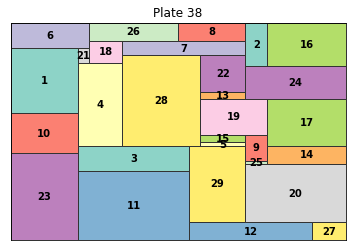

Instance[38] solved in 111.801 s, height: 60




In [11]:
from_ins = 38
to_ins   = 38

for ins in range(from_ins, min(to_ins+1,41)):
    print('========================================================================================')

    # Instance
    instance=utils.loadInstance(f"../instances/ins-{ins}.txt")
    print("Instance:",*["{}={}".format(key,val) for key,val in instance.items()])

    # Solving
    s,x,y,H,e_time = vlsi_sat(instance)
    
    if e_time == 0.0:
        print("Out of time")
    else:
        m = s.model()
        n = instance['n']
        W = instance['w']
        widths  = [i[0] for i in instance['dim']]
        heights = [i[1] for i in instance['dim']]

        # Get coordinates
        cx, cy = getCoords(m,x,y,W,sum(heights),n)

        write_file(W, H, n, widths,
                   heights, cx, cy, './outputs_opt/out-' + str(ins) + '.txt')

        # Display
        l=read(f"./outputs_opt/out-{ins}.txt")
        display_solution(f'Plate {ins}', l[0][0], l[0][1], len(l)-1,\
                         [i[:2] for i in l[1:][:]], [i[2:] for i in l[1:][:]])

        # Time
        print(f'Instance[{ins}] solved in {round(e_time,3)} s, height: {H}')
    print('========================================================================================')
    print('\n')